# Determining the causal kernel for large

We would like to consider a complex function $R^p(\omega)=\rho(\omega)e^{i\phi(\omega)}$. For $\omega\in R$ along the real axis, we know
$\rho(\omega)=\frac{2^{\Delta -1}\sqrt{\pi}}{\sqrt{\Gamma(2\Delta)}(\cos\theta)^{\Delta+\frac12}}\left|\frac{\Gamma\left(\Delta+i\frac{\omega}{4T\theta}\right)}{\Gamma\left(\frac12+i\frac{\omega}{2\pi T}\right)}\right|$. Here $\theta\in(0,\pi/2)$ is determined by the equation
$\frac{\cos\theta}{\theta}=2T$, with $T>0$. $\Delta$ is a real number $0<\Delta<\frac12$.

We would like to determine this complex function using the Kramers-Kronig relation. Noticing that $\log\rho(\omega)\propto \left|\omega\right|\left(\frac1{4T}-\frac{\pi}{8T\theta}\right)$ in large real $\omega$, and also notice $\rho(\omega)=\rho(-\omega)$, we need to subtract the divergent term and do KK relation with $\frac{\log\rho(\omega)-\log\rho(0)}{\omega^2}$, which leads to the equation
\begin{align}
    \phi(\omega)=\omega^2\mathcal{P}\int_{-\infty}^{+\infty}d\omega'\frac{\log\rho(\omega')-\log\rho(0)}{\omega'^2\left(\omega'-\omega\right)}
\end{align}

Based on this construction, numerically carry the following calculation:
- Compute $\phi(\omega)$ for real $\omega$;
- Fourier transform $R^p(\omega)$ (for real $\omega$) to obtain $\tilde{R}^p(t)$ and plot this function. We need to confirm that $\tilde{R}^p(t)=0$ for $t>0$;
- Assuming $R^p(\omega)$ to be analytic in the upper half plane, compute the value of $R^p(\omega)$ in the upper half plane by Cauchy integral.

## Define Functions $R^p(\omega)$ and $\tilde{R}^p(t)$

`kernel_real_omega2` defines the kernel $R^p(\omega)$ for real $\omega$ by direct Hilbert transform. Then `analytic_continuation_from_amplitude` defines the $R^p(\omega)$ for complex omega in upper half plane by Cauchy integral. These two functions are defined for generic amplitude function `amplitude(omega,**kwargs)` as an input variable. The amplitude function for SYK large $q$ is defined by `amplitude_SYK`. Other functions support these three functions.

This notebook depends on `kramers_kronig.calculate_R_t`. It does not depend on other functions in `kramers_kronig.py` and `finding_imag.py`.

In [1]:

from sys import executable
import numpy as np
from scipy.special import gamma, loggamma, polygamma
from scipy.optimize import fsolve
from scipy.integrate import quad
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.integrate import quad
from scipy.interpolate import interp1d, RectBivariateSpline
from scipy.integrate import trapezoid

def equation_for_theta(theta):
    return np.cos(theta) / theta - 2 * T

def prepare_parameters(T, Delta):
    theta = fsolve(equation_for_theta, 0.4)[0]
    C = (2**(Delta - 1) * np.sqrt(np.pi)) / (np.sqrt(gamma(2 * Delta)) * (np.cos(theta))**(Delta + 0.5))
    a = 4 * T * theta
    b = 2 * np.pi * T
    return C, a, b

def log_rho(omega, Delta, T):
    """Computes log(rho(omega))"""
    C, a, b = prepare_parameters(T, Delta)
    log_gamma_val1 = loggamma(Delta + 1j * omega / a)
    log_gamma_val2 = loggamma(0.5 + 1j * omega / b)
    return np.log(C) + np.real(log_gamma_val1) - np.real(log_gamma_val2)

def R_from_gamma(omega,Delta,T):
    """The naive R(omega) defined analytically, which is analytic in upper half plane, but does not satisfy causality because the divergence in large |omega|"""
    C, a, b = prepare_parameters(T, Delta)
    R_w=C*gamma(Delta-1j*omega/a)/gamma(0.5-1j*omega/b)
    return R_w

def spectral_SYK(omega,Delta,T):
    """The spectral function of SYK"""
    R_p=R_from_gamma(omega,Delta,T)
    R_f=R_from_gamma(-omega,Delta,T)
    return R_p*R_f

def amplitude_SYK(omega,Delta,T):
    return np.exp(log_rho(omega,Delta,T))

def g(omega,Delta,T):
    """(log(rho)-log(rho(0))/omega^2"""
    log_rho_0 = log_rho(0,Delta,T)
    C, a, b = prepare_parameters(T, Delta)
    log_rho_double_prime_at_zero = -(1/a**2) * polygamma(1, Delta) + (1/b**2) * polygamma(1, 0.5)
    # Vectorize to handle both scalar and array inputs
    omega_arr = np.atleast_1d(omega)
    result = np.where(
        np.abs(omega_arr) < 1e-9,
        0.5 * log_rho_double_prime_at_zero,
        (log_rho(omega_arr, Delta, T) - log_rho_0) / (omega_arr**2)
    )
    return result if omega_arr.shape != (1,) else result[0]


def kernel_real_omega(omega,Delta,T):
    "Causal kernel R^f"
    alpha_w = g(omega,Delta,T)
    beta_w = np.imag(hilbert(alpha_w))
    log_rho_w = log_rho(omega,Delta,T)
    phi = beta_w * omega**2
    R=np.exp(log_rho_w + 1j * phi)
    return R, phi, beta_w

def kernel_real_omega2(omega,amplitude,**kwargs):
    """obtain the analytic continuation from the value of amplitude on the real axis, from direct Hilbert transform. omega is along the real axis"""
    # determine phase from amplitude
    log_R = hilbert(np.log(amplitude(omega,**kwargs)))
    return np.exp(log_R)


def cauchy_integral_upper(z, R_interp_func, real_axis):
    if z.imag <= 0:
        return np.nan
    integrand = R_interp_func(real_axis) / (real_axis - z)
    return trapezoid(integrand, real_axis) / (2j * np.pi)

def analytic_continuation_from_amplitude(z,omega_real,amplitude, **kwargs):
    """Obtain the analytic continuation in the upper half plane from function amplitude at real axis"""
    R_w = kernel_real_omega2(omega_real,amplitude,**kwargs)
    R_interp_real = interp1d(omega_real, R_w, kind='cubic', bounds_error=False, fill_value=0)
    R_complex = cauchy_integral_upper(z, R_interp_real, omega_real)
    return R_complex
    
    



## Compare the $\tilde{R}^p(\omega)$ with the naive $\tilde{R}^p_\Gamma(\omega)$

## Plot $R^p(\omega)$ and $\tilde{R}^p(t)$

We plot the frequency and time domain responses. We also compare it with the naive choice $R^p_{\Gamma}(\omega)=\frac{2^{\Delta -1}\sqrt{\pi}}{\sqrt{\Gamma(2\Delta)}(\cos\theta)^{\Delta+\frac12}}\frac{\Gamma\left(\Delta-i\frac{\omega}{4T\theta}\right)}{\Gamma\left(\frac12-i\frac{\omega}{2\pi T}\right)}$. Naively this choice is analytic in upper halfplane, but it is not causal in time because of the divergence at large imaginary $\omega$. 

### Comparison in time domain

Calculating and plotting R(t)...


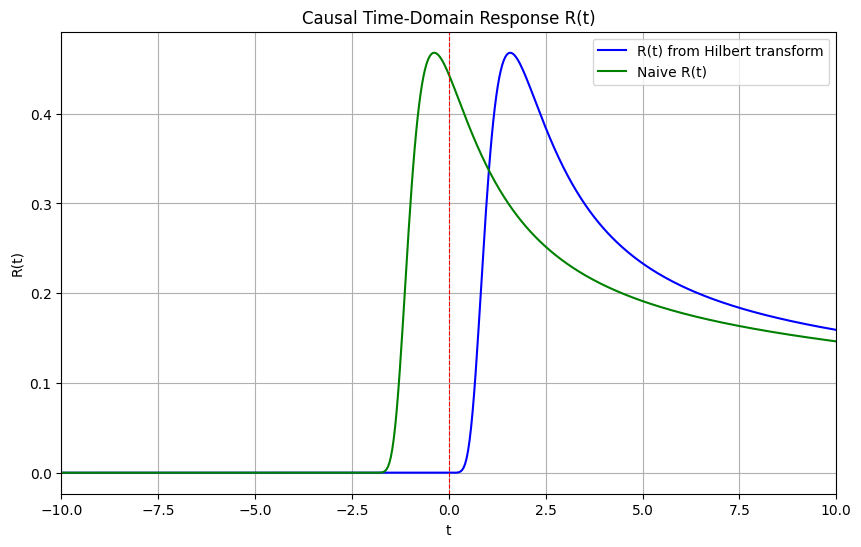

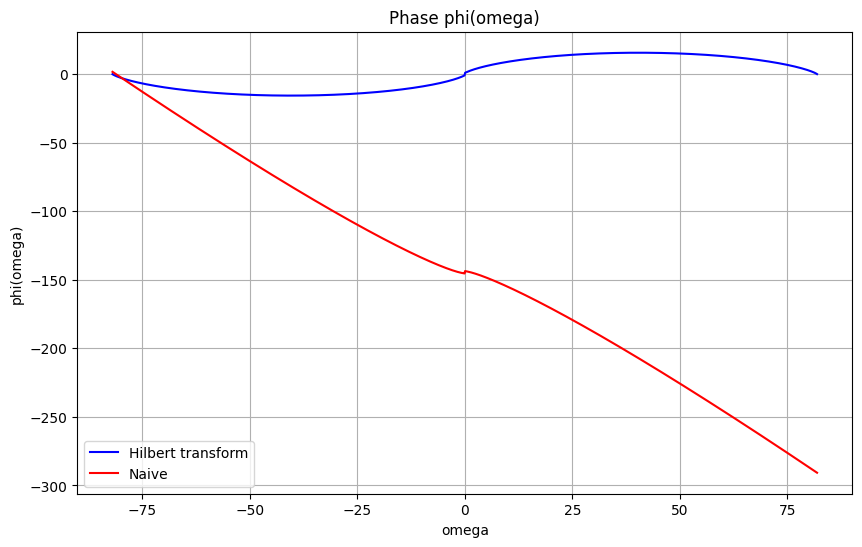


Maximum absolute value of R(t) for t < 0: 2.68e-05
Verification successful: R(t) is effectively zero for t < 0.


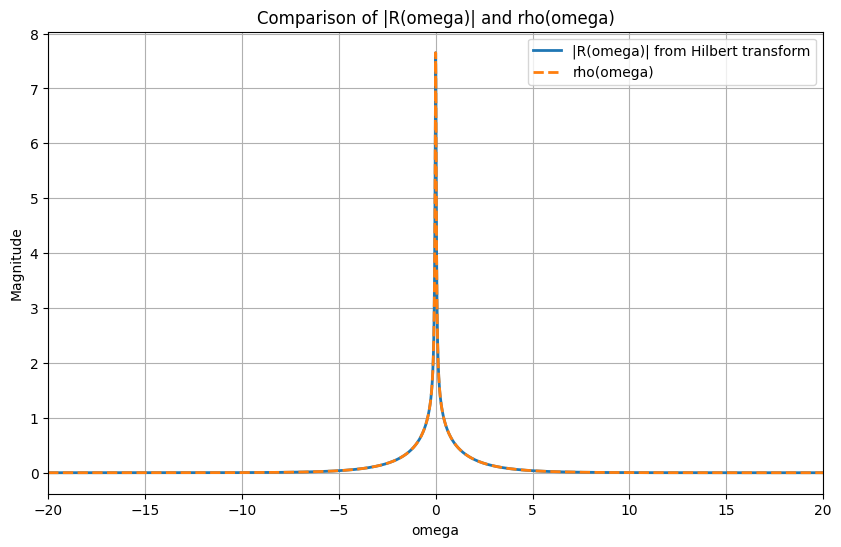

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
from kramers_kronig import calculate_R_t
from finding_imag import imag_f_from_even_F



Delta = 0.1
T = 0.05

# Define a dense grid of real frequencies 

N_points = 2**14
dw_step = 0.01
w_max_val = (N_points / 2) * dw_step
omega_real_dense = np.linspace(-w_max_val, w_max_val - dw_step, N_points)


# Calculate R(omega) on the real axis using Hilbert transform

# R_omega_real_values, phi, beta_w=kernel_real_omega(omega_real_dense,Delta,T)

# log_rho_w = log_rho(omega_real_dense, Delta, T)
#phi = imag_f_from_even_F(omega_real_dense, log_rho_w)
# R_omega_real_values = np.exp(log_rho_w + 1j*phi)

#log_rho_w= log_rho(omega_real_dense, Delta, T)
#phi = np.imag(hilbert(log_rho_w))
#R_omega_real_values = np.exp(log_rho_w + 1j*phi)

R_omega_real_values = kernel_real_omega2(omega_real_dense,amplitude_SYK,Delta=Delta,T=T)
phi = np.unwrap(np.imag(np.log(R_omega_real_values)))

R_naive = R_from_gamma(omega_real_dense, Delta, T)
phi_naive = np.unwrap(np.imag(np.log(R_naive)))

#Calculate the time-domain response and verify causality

print("Calculating and plotting R(t)...")
t_values, R_t_values = calculate_R_t(R_omega_real_values, omega_real_dense)
t_values2, R_t_values2 = calculate_R_t(R_naive, omega_real_dense)

plt.figure(figsize=(10, 6))
plt.plot(t_values, R_t_values,'b-',label='R(t) from Hilbert transform')
plt.plot(t_values2, R_t_values2,'g-',label='Naive R(t)')
plt.title('Causal Time-Domain Response R(t)')
plt.xlabel('t')
plt.ylabel('R(t)')
plt.legend()
plt.xlim(-10, 10)
plt.grid(True)
plt.axvline(0, color='r', linestyle='--', linewidth=0.8)
plt.show()

# plot phi
plt.figure(figsize=(10, 6))
plt.plot(omega_real_dense, phi,'b-',label='Hilbert transform')
plt.plot(omega_real_dense, phi_naive,'r-',label='Naive')
plt.title('Phase phi(omega)')
plt.xlabel('omega')
plt.ylabel('phi(omega)')
plt.legend()
plt.grid(True)
plt.show()

t_negative_mask = t_values < -1e-6 # Use a small tolerance
max_val_for_negative_t = np.max(np.abs(R_t_values[t_negative_mask]))
print(f"\nMaximum absolute value of R(t) for t < 0: {max_val_for_negative_t:.2e}")
if max_val_for_negative_t < 1e-3:
    print("Verification successful: R(t) is effectively zero for t < 0.")
else:
    print("Verification failed: R(t) is not zero for t < 0.")

# plot |R(omega)| vs rho(omega)
plt.figure(figsize=(10, 6))
R_magnitude = np.abs(R_omega_real_values)
rho_from_log = np.exp(log_rho(omega_real_dense, Delta, T))
plt.plot(omega_real_dense, R_magnitude, label='|R(omega)| from Hilbert transform', linewidth=2)
plt.plot(omega_real_dense, rho_from_log, label='rho(omega)', linestyle='--', linewidth=2)
plt.title('Comparison of |R(omega)| and rho(omega)')
plt.xlabel('omega')
plt.ylabel('Magnitude')
plt.legend()
plt.grid(True)
plt.xlim(-20, 20)  # Adjust range as needed
plt.show()





### More refined comparison of $\tilde{R}^p(t)$ and the naive $\tilde{R}_\Gamma^p(t)$ by translation in time

We see that the two functions are almost the same up to a translation in time, but not exactly the same.

Optimal time shift c = 1.961771
Minimum difference = 5.443329e-07


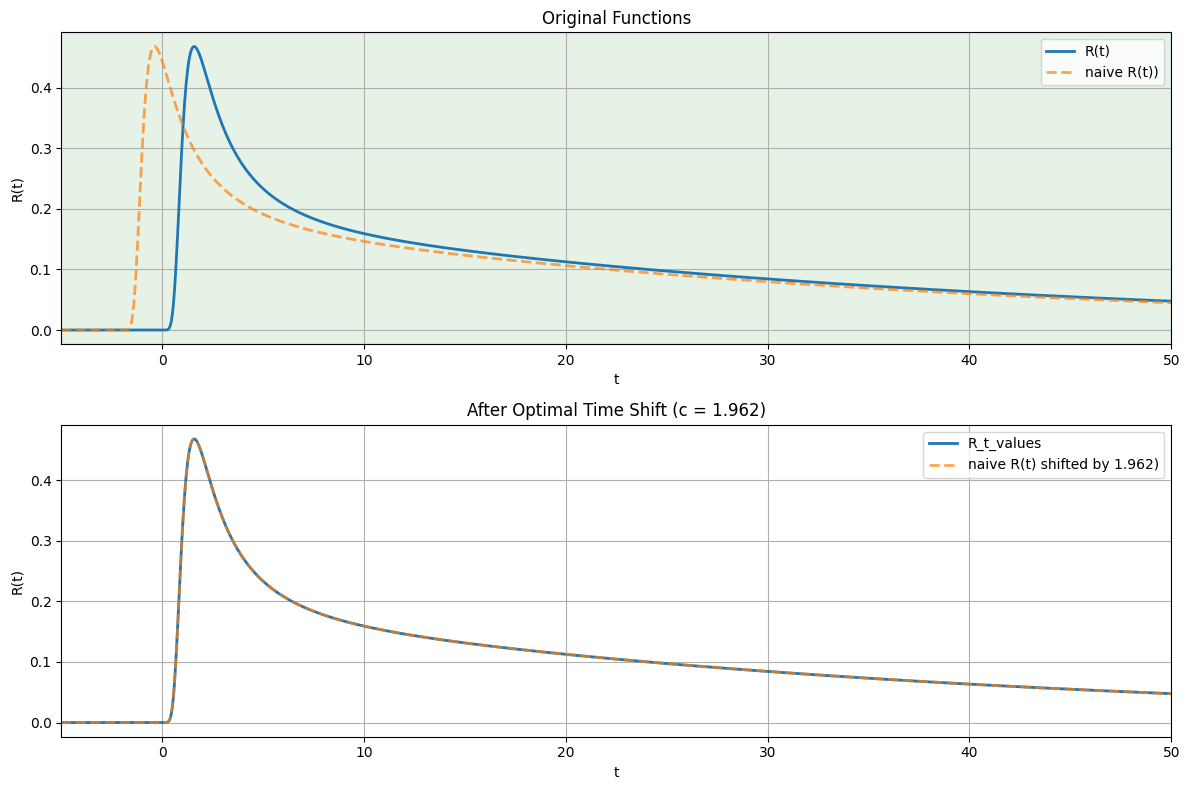

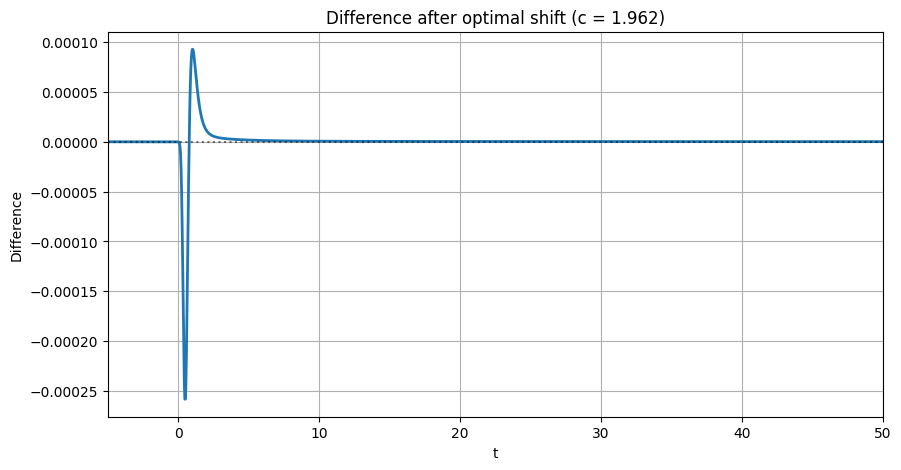

In [4]:
from scipy.optimize import minimize_scalar
from scipy.interpolate import interp1d

# Focus on time window [-5, 50]
mask = (t_values >= -5) & (t_values <= 50)
t_fit = t_values[mask]
R_fit = R_t_values[mask]

bound_c=10

# Define a function to compute the difference in the focused window
def difference_metric(c):
    """Compute L2 difference between R_t_values and R_t_values2 shifted by c"""
    # Create interpolator for R_t_values2
    interp_R2 = interp1d(t_values2, R_t_values2, kind='linear', 
                         bounds_error=False, fill_value=0)
    
    # Evaluate R_t_values2 at shifted times (only in the fit window)
    R2_shifted = interp_R2(t_fit - c)
    
    # Compute L2 norm of difference
    diff = np.sum((R_fit - R2_shifted)**2)
    return diff

# Find optimal shift with wider search range
result = minimize_scalar(difference_metric, bounds=(-bound_c, bound_c), method='bounded')
optimal_c = result.x

print(f"Optimal time shift c = {optimal_c:.6f}")
print(f"Minimum difference = {result.fun:.6e}")

# Apply the optimal shift for plotting
interp_R2 = interp1d(t_values2, R_t_values2, kind='linear', 
                     bounds_error=False, fill_value=0)
R_t_values2_shifted = interp_R2(t_values - optimal_c)

# Plot comparison focused on [-5, 50]
plt.figure(figsize=(12, 8))

# Plot 1: Original functions
plt.subplot(2, 1, 1)
plt.plot(t_values, R_t_values, label='R(t)', linewidth=2)
plt.plot(t_values2, R_t_values2, label='naive R(t))', 
         linestyle='--', linewidth=2, alpha=0.7)
plt.xlabel('t')
plt.ylabel('R(t)')
plt.title('Original Functions')
plt.legend()
plt.grid(True)
plt.xlim(-5, 50)
plt.axvspan(-5, 50, alpha=0.1, color='green', label='Fit region')

# Plot 2: After optimal shift
plt.subplot(2, 1, 2)
plt.plot(t_values, R_t_values, label='R_t_values', linewidth=2)
plt.plot(t_values, R_t_values2_shifted, label=f'naive R(t) shifted by {optimal_c:.3f})', 
         linestyle='--', linewidth=2, alpha=0.7)
plt.xlabel('t')
plt.ylabel('R(t)')
plt.title(f'After Optimal Time Shift (c = {optimal_c:.3f})')
plt.legend()
plt.grid(True)
plt.xlim(-5, 50)

plt.tight_layout()
plt.show()

# Plot the difference in the fit region
plt.figure(figsize=(10, 5))
plt.plot(t_values, R_t_values - R_t_values2_shifted, linewidth=2)
plt.xlabel('t')
plt.ylabel('Difference')
plt.title(f'Difference after optimal shift (c = {optimal_c:.3f})')
plt.grid(True)
plt.xlim(-5, 50)
plt.axhline(0, color='k', linestyle=':', alpha=0.5)
plt.show()

### Comparison for complex frequency

The comparison shows that for low temperature $R^p(\omega)$ is close to the naive result, but they deviate quickly for high frequency and high temperature.

<>:16: SyntaxWarning: invalid escape sequence '\G'
<>:17: SyntaxWarning: invalid escape sequence '\o'
<>:18: SyntaxWarning: invalid escape sequence '\o'
<>:37: SyntaxWarning: invalid escape sequence '\G'
<>:38: SyntaxWarning: invalid escape sequence '\o'
<>:39: SyntaxWarning: invalid escape sequence '\o'
<>:16: SyntaxWarning: invalid escape sequence '\G'
<>:17: SyntaxWarning: invalid escape sequence '\o'
<>:18: SyntaxWarning: invalid escape sequence '\o'
<>:37: SyntaxWarning: invalid escape sequence '\G'
<>:38: SyntaxWarning: invalid escape sequence '\o'
<>:39: SyntaxWarning: invalid escape sequence '\o'
/var/folders/xx/809jr4w13lqgcx62t5s5tm380000gn/T/ipykernel_54250/1265988935.py:16: SyntaxWarning: invalid escape sequence '\G'
  plt.plot(np.imag(zs),np.real(R_a),'r-',label='naive $R^p_\Gamma(\omega)$')
/var/folders/xx/809jr4w13lqgcx62t5s5tm380000gn/T/ipykernel_54250/1265988935.py:17: SyntaxWarning: invalid escape sequence '\o'
  plt.plot(np.imag(zs),np.real(R_n),'b-',label='numeric $

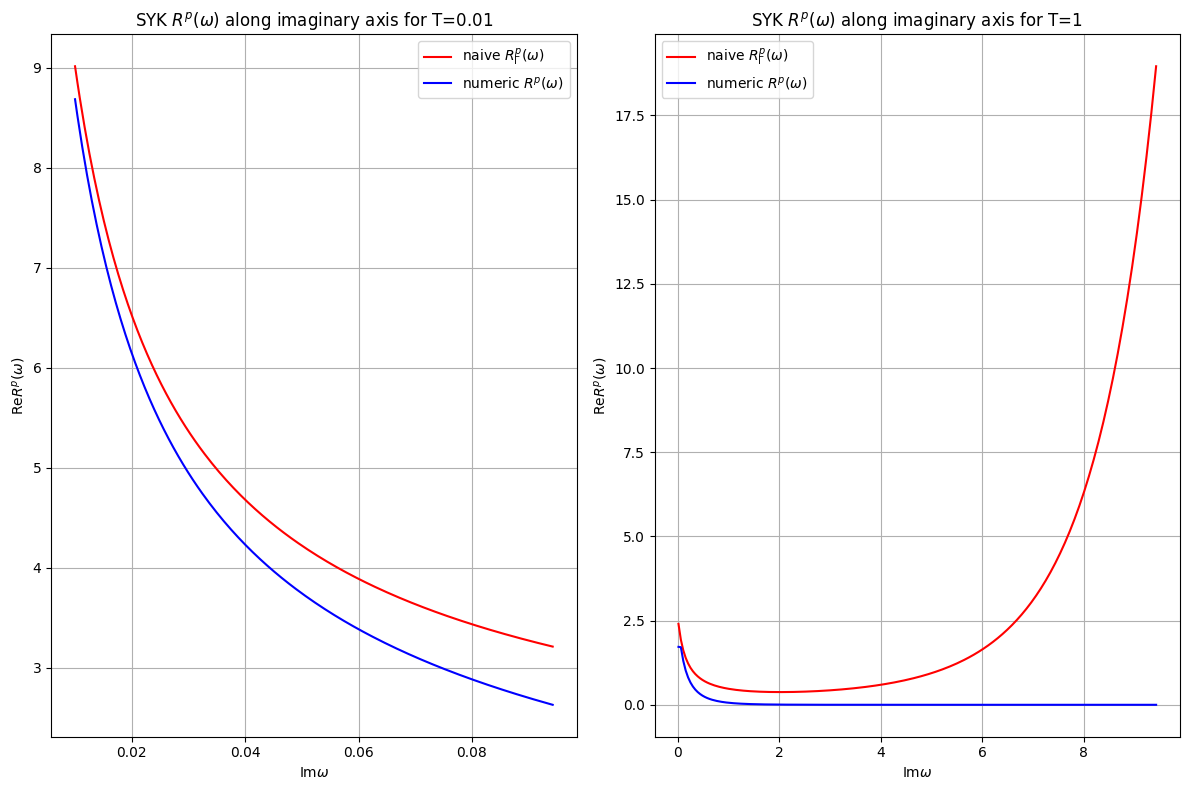

In [5]:


Delta=0.1
T=0.01
omega_real_dense = np.linspace(-100*np.pi*T, 100*np.pi*T, 10000)
zs = np.linspace(0.01,3*np.pi*T,200)*1j
R_n=[]
R_a=[]
for z in zs:

    R_complex = analytic_continuation_from_amplitude(z,omega_real_dense,amplitude_SYK,Delta=Delta,T=T)
    R_n.append(R_complex)
    R_a.append(R_from_gamma(z,Delta,T))


plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
plt.plot(np.imag(zs),np.real(R_a),'r-',label='naive $R^p_\Gamma(\omega)$')
plt.plot(np.imag(zs),np.real(R_n),'b-',label='numeric $R^p(\omega)$')
plt.title(f'SYK $R^p(\omega)$ along imaginary axis for T={T}')
plt.xlabel(r'Im$\omega$')
plt.ylabel(r'Re$R^p(\omega)$')
plt.legend()
plt.grid(True)

T=1
omega_real_dense = np.linspace(-100*np.pi*T, 100*np.pi*T, 10000)
zs = np.linspace(0.01,3*np.pi*T,200)*1j
R_n=[]
R_a=[]
for z in zs:

    R_complex = analytic_continuation_from_amplitude(z,omega_real_dense,amplitude_SYK,Delta=Delta,T=T)
    R_n.append(R_complex)
    R_a.append(R_from_gamma(z,Delta,T))


plt.subplot(1,2,2)
plt.plot(np.imag(zs),np.real(R_a),'r-',label='naive $R^p_\Gamma(\omega)$')
plt.plot(np.imag(zs),np.real(R_n),'b-',label='numeric $R^p(\omega)$')
plt.title(f'SYK $R^p(\omega)$ along imaginary axis for T={T}')
plt.xlabel(r'Im$\omega$')
plt.ylabel(r'Re$R^p(\omega)$')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Sanity check 

Check that the analytic continuation works for simple functions, such as 
${\rm amplitude}(\omega)=\prod_i\frac1{\sqrt{\omega^2+J_i^2}}$, $R(\omega)=\prod_i\frac1{\omega-iJ_i}$ with $J_i>0$.

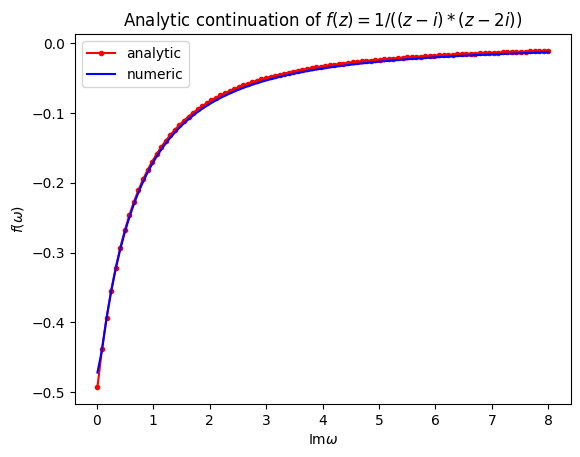

In [6]:
def example_func(omega):
    return 1/np.sqrt((omega**2+1)*(omega**2+4))

omega_real_dense = np.linspace(-100, 100, 10000)

zs = np.linspace(0.01,8,100)*1j
R_n=[]
R_a=[]
for z in zs:

    R_complex = analytic_continuation_from_amplitude(z,omega_real_dense,example_func)
    R_n.append(R_complex)
    R_a.append(1/((z+1j)*(z+2j)))


plt.figure()
plt.plot(np.imag(zs),np.real(R_a),'r.-',label='analytic')
plt.plot(np.imag(zs),-np.real(R_n),'b-',label='numeric')
plt.title(r'Analytic continuation of $f(z)=1/((z-i)*(z-2i))$')
plt.xlabel(r'Im$\omega$')
plt.ylabel(r'$f(\omega)$')
plt.legend()
plt.show()

## Compute $R(\omega)$ for complex $\omega$

Starting from the real $\omega$, define the upper half plane value of $R^p(\omega)$ by Cauchy integral, and then define the lower half-plane value by 
$R^p(\omega)=\frac{A(\omega)}{R^p(-\omega)}$.

Calculating R(z) in the upper half-plane via Cauchy Integral...
Upper half-plane calculation complete.

Calculating R(z) for the full complex plane...
Full plane calculation complete.


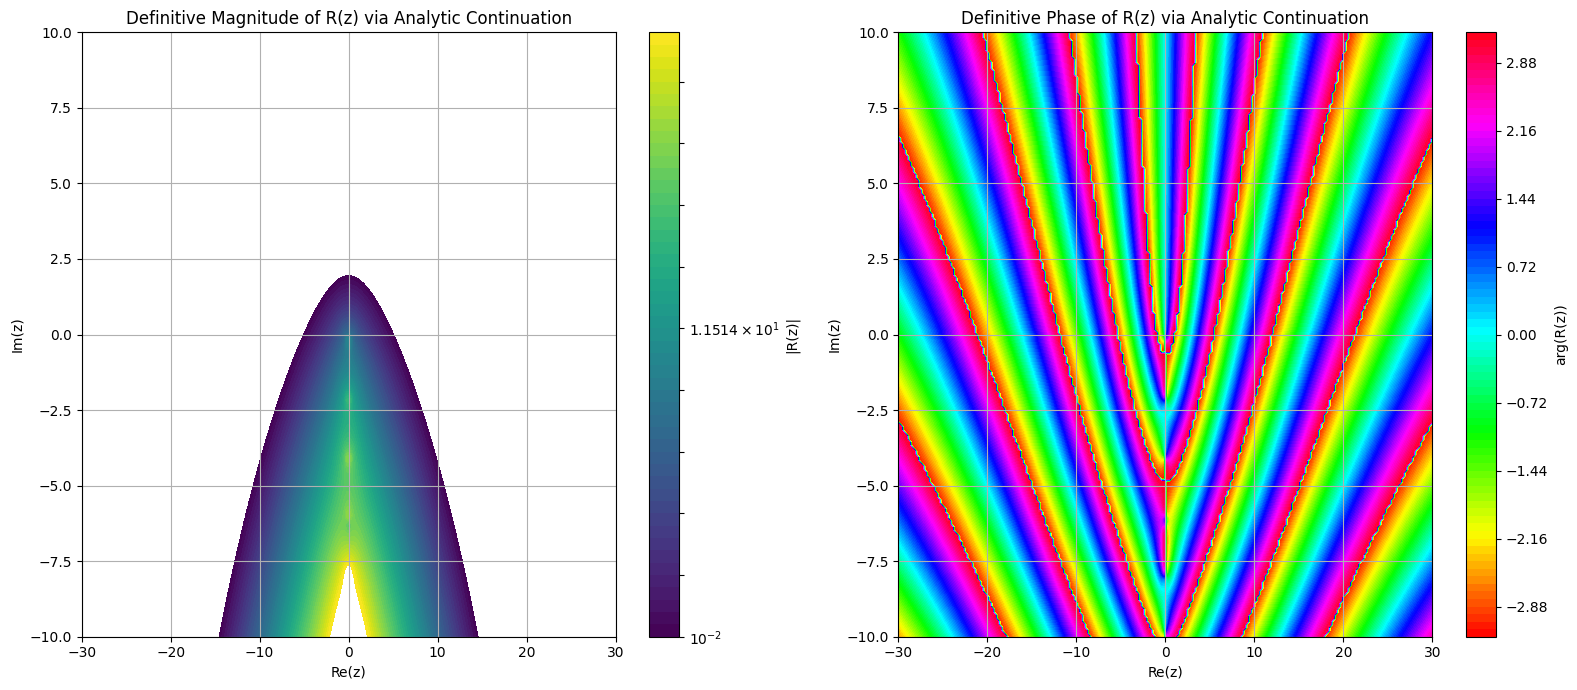

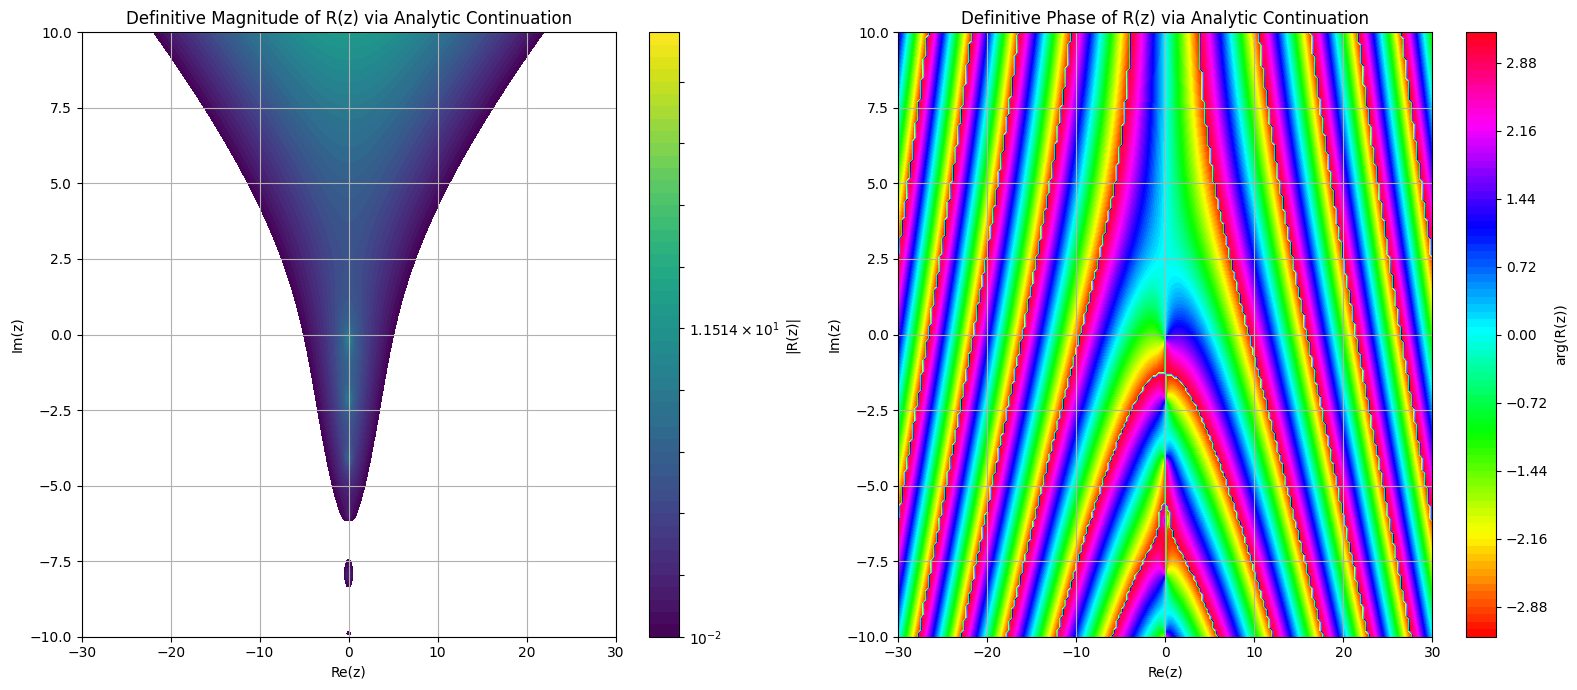

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, RectBivariateSpline
from scipy.integrate import trapezoid
from scipy.special import gamma

# -----------------------------------------------------------------------------
# Final Correct Implementation: Analytic Continuation from Real-Axis Data
# -----------------------------------------------------------------------------

# --- 1. Setup Data and Functions ---

# R_omega_real_values is from the validated Kramers-Kronig calculation.
# Create a 1D interpolator for the real-axis data.
# R_interp_real = interp1d(omega_real_dense, R_omega_real_values, kind='cubic', bounds_error=False, fill_value=0)

T=2
Delta=0.1
omega_real_dense = np.linspace(-np.pi*T*20, np.pi*T*20, 10000)

omega_r_grid_upper = np.linspace(-30, 30, 150)
omega_i_grid_upper = np.linspace(0.01, 10, 75)
R_omega_upper_plane = np.zeros((len(omega_i_grid_upper), len(omega_r_grid_upper)), dtype=complex)

print("Calculating R(z) in the upper half-plane via Cauchy Integral...")
for i, imag_val in enumerate(omega_i_grid_upper):
    for j, real_val in enumerate(omega_r_grid_upper):
        z = real_val + 1j * imag_val
        R_omega_upper_plane[i, j] = analytic_continuation_from_amplitude(z,omega_real_dense,amplitude_SYK,Delta=Delta,T=T)
print("Upper half-plane calculation complete.")

# --- 3. Create a 2D Interpolator for the UHP ---

interp_R_upper_real = RectBivariateSpline(omega_i_grid_upper, omega_r_grid_upper, R_omega_upper_plane.real)
interp_R_upper_imag = RectBivariateSpline(omega_i_grid_upper, omega_r_grid_upper, R_omega_upper_plane.imag)

# --- 4. Calculate R(z) for the Full Plane ---

omega_r_plot = np.linspace(-30, 30, 200)
omega_i_plot = np.linspace(-10, 10, 200)
Omega_r_mesh, Omega_i_mesh = np.meshgrid(omega_r_plot, omega_i_plot)
Z_grid = Omega_r_mesh + 1j * Omega_i_mesh
R_naive_full_plane = np.zeros_like(Z_grid, dtype=complex)
R_omega_full_plane = np.zeros_like(Z_grid, dtype=complex)

print("\nCalculating R(z) for the full complex plane...")
for i in range(len(omega_i_plot)):
    for j in range(len(omega_r_plot)):
        z = Z_grid[i, j]
        
        R_naive_full_plane[i,j] = R_from_gamma(z,Delta,T)
        if z.imag >= 0:
            R_omega_full_plane[i, j] = (interp_R_upper_real(z.imag + 1e-6, z.real)[0,0] +
                                        1j * interp_R_upper_imag(z.imag + 1e-6, z.real)[0,0])
        else:
            z_reflected = -z
            A_z = R_from_gamma(z,Delta,T)*R_from_gamma(z_reflected,Delta,T)
            
            R_reflected = (interp_R_upper_real(z_reflected.imag, z_reflected.real)[0,0] +
                           1j * interp_R_upper_imag(z_reflected.imag, z_reflected.real)[0,0])
            
            if np.abs(R_reflected) > 1e-12:
                R_omega_full_plane[i, j] = A_z/R_reflected
            else:
                R_omega_full_plane[i, j] = np.nan
print("Full plane calculation complete.")

# --- 5. Plot the Definitive Results ---

plt.figure(figsize=(16, 7))

# Magnitude plot
plt.subplot(1, 2, 1)
magnitude = np.abs(R_omega_full_plane)
from matplotlib.colors import LogNorm
plt.contourf(omega_r_plot, omega_i_plot, magnitude, levels=np.logspace(-2, 4, 50), cmap='viridis', norm=LogNorm())
plt.colorbar(label='|R(z)|')
plt.title('Definitive Magnitude of R(z) via Analytic Continuation')
plt.xlabel('Re(z)')
plt.ylabel('Im(z)')
plt.grid(True)

# Phase plot
plt.subplot(1, 2, 2)
phase = np.angle(R_omega_full_plane)
plt.contourf(omega_r_plot, omega_i_plot, phase, levels=100, cmap='hsv')
plt.colorbar(label='arg(R(z))')
plt.title('Definitive Phase of R(z) via Analytic Continuation')
plt.xlabel('Re(z)')
plt.ylabel('Im(z)')
plt.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 7))

# Magnitude plot
plt.subplot(1, 2, 1)
magnitude = np.abs(R_naive_full_plane)
from matplotlib.colors import LogNorm
plt.contourf(omega_r_plot, omega_i_plot, magnitude, levels=np.logspace(-2, 4, 50), cmap='viridis', norm=LogNorm())
plt.colorbar(label='|R(z)|')
plt.title('Definitive Magnitude of R(z) via Analytic Continuation')
plt.xlabel('Re(z)')
plt.ylabel('Im(z)')
plt.grid(True)

# Phase plot
plt.subplot(1, 2, 2)
phase = np.angle(R_naive_full_plane)
plt.contourf(omega_r_plot, omega_i_plot, phase, levels=100, cmap='hsv')
plt.colorbar(label='arg(R(z))')
plt.title('Definitive Phase of R(z) via Analytic Continuation')
plt.xlabel('Re(z)')
plt.ylabel('Im(z)')
plt.grid(True)

plt.tight_layout()
plt.show()

## Compute the IR curvature from zeros of spectral function

The curvature is given by the formula
$\frac{R}{m^2}=-\frac12\left(1+\frac{4\lambda_0^2\beta_1}{\beta_0^3}\right)$. This is determined by the S-matrix
$S(\omega)=\frac{R^p(\omega)}{R^p(-\omega)}=\frac{R^p(\omega)^2}{A(-\omega)}$

Here $\lambda_0,\lambda_1$ is the first pole of $S(\omega)$ in the upper half plane, and $\beta_0,\beta_1$ are the corresponding residuals. Since $R^p(\omega)$ has no pole in the upper half plane, $\lambda_0,\lambda_1$ are determined by zeros of $A(-\omega)$. For SYK model, $\lambda_0=i\pi T,~\lambda_1=3i\pi T$. $\beta_0,\beta_1$ can be computed as
$\beta_0=\frac{R^p(\lambda_0)^2}{A'(-\lambda_0)}$ and similar for $\beta_1$. The derivative $A'(-\lambda_{0,1})$ is known analytically, so we just need to numerically compute $R^p(\lambda_{0,1})$ by Cauchy integral. 

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import trapezoid
from scipy.special import gamma



def A_prime_at_zero(n, a, b, C, Delta):
    """Robustly calculates A'(z_n) at the n-th zero of A(z)."""
    gamma_func_vec = np.vectorize(gamma)
    # N(z_n) = Gamma(Delta - n - 0.5) * Gamma(Delta + n + 0.5)
    N_zn = gamma_func_vec(Delta - (n+0.5)*b/a) * gamma_func_vec(Delta + (n+0.5)*b/a)
    # Formula for the derivative at the simple zero z_n
    A_prime = -1j * (1/b) * ((-1)**n) * (C**2) * N_zn
    return A_prime

# --- 2. Main Calculation Loop ---

T_values = np.linspace(0.01, 5, 1000)
residues_pole0 = []
residues_pole1 = []
curvature = []
R_z0_list = []
R_z1_list = []
R_naive_z0_list = []
R_naive_z1_list = []
residues_pole0_naive = []
residues_pole1_naive = []

curvature_naive = []

# Parameters (C and Delta are constant)

Delta_val = Delta

print("Calculating residues as a function of temperature...")
for T in T_values:
    C_val, a_val, b_val = prepare_parameters(T, Delta_val)

    # Pole locations for this T
    z0 = 1j * b_val * 0.5
    z1 = 1j * b_val * 1.5

    # a. Calculate R(w) on the real axis for this T
    N_points = 20000
    w_max_val = 20 * b_val # Ensure omega range is large enough
    omega_real_dense_T = np.linspace(-w_max_val, w_max_val, N_points)

    #R_omega_real_T, _, _ = kernel_real_omega(omega_real_dense_T, Delta_val,T)
    
    # b. Create a 1D interpolator
    #R_interp_T = interp1d(omega_real_dense_T, R_omega_real_T, kind='cubic', bounds_error=False, fill_value=0)

    # c. Calculate R(z_n) using Cauchy integral
    R_at_z0 = analytic_continuation_from_amplitude(z0,omega_real_dense_T,amplitude_SYK,Delta=Delta_val,T=T)
    R_at_z1 = analytic_continuation_from_amplitude(z1,omega_real_dense_T,amplitude_SYK,Delta=Delta_val,T=T)
    R_z0_list.append(R_at_z0)
    R_z1_list.append(R_at_z1)

    R_naive_z0_list.append(R_from_gamma(z0,Delta_val,T))
    R_naive_z1_list.append(R_from_gamma(z1,Delta_val,T))

    # d. Calculate A'(z_n) using the robust analytic formula
    A_prime_at_z0 = A_prime_at_zero(0, a_val, b_val, C_val, Delta_val)
    A_prime_at_z1 = A_prime_at_zero(1, a_val, b_val, C_val, Delta_val)

    # e. Compute the residues
    res_z0 = R_at_z0**2 / A_prime_at_z0
    res_z1 = R_at_z1**2 / A_prime_at_z1

    res_z0_naive = R_naive_z0_list[-1]**2 / A_prime_at_z0
    res_z1_naive = R_naive_z1_list[-1]**2 / A_prime_at_z1

    residues_pole0.append(np.abs(res_z0))
    residues_pole1.append(np.abs(res_z1))
    
    residues_pole0_naive.append(np.abs(res_z0_naive))
    residues_pole1_naive.append(np.abs(res_z1_naive))

    curvature.append(-1/2-2*(z0**2)*res_z1/res_z0**3)
    curvature_naive.append(-1/2-2*(z0**2)*res_z1_naive/res_z0_naive**3)

print("Calculation complete.")



Calculating residues as a function of temperature...
Calculation complete.


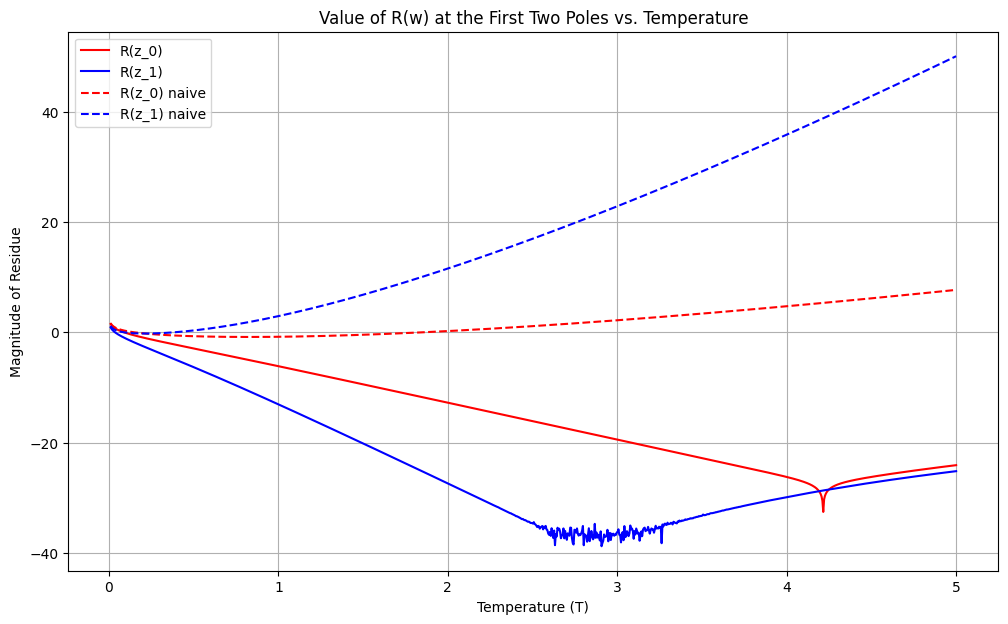

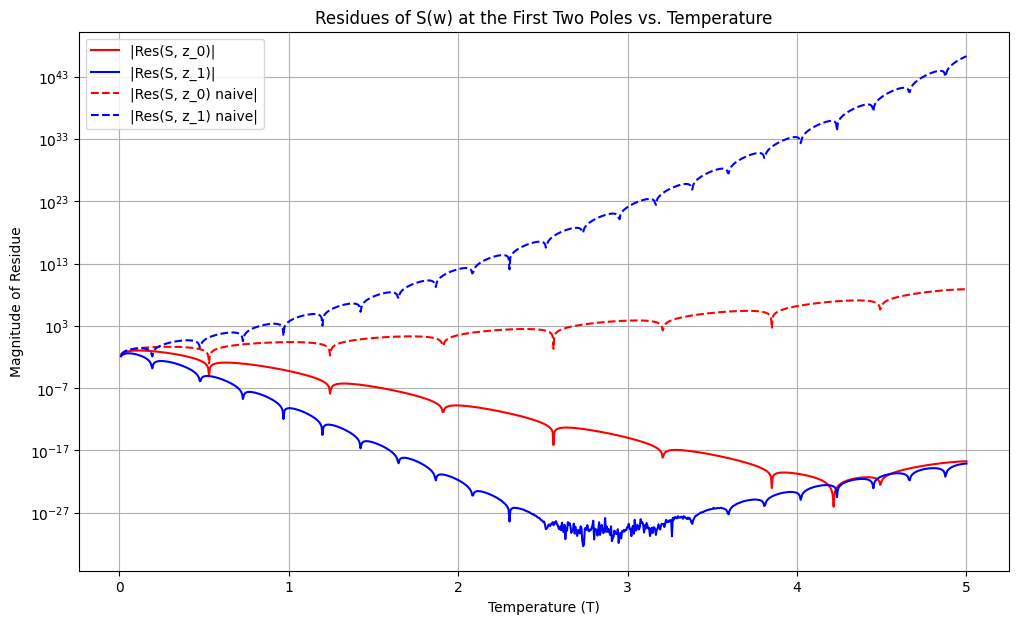

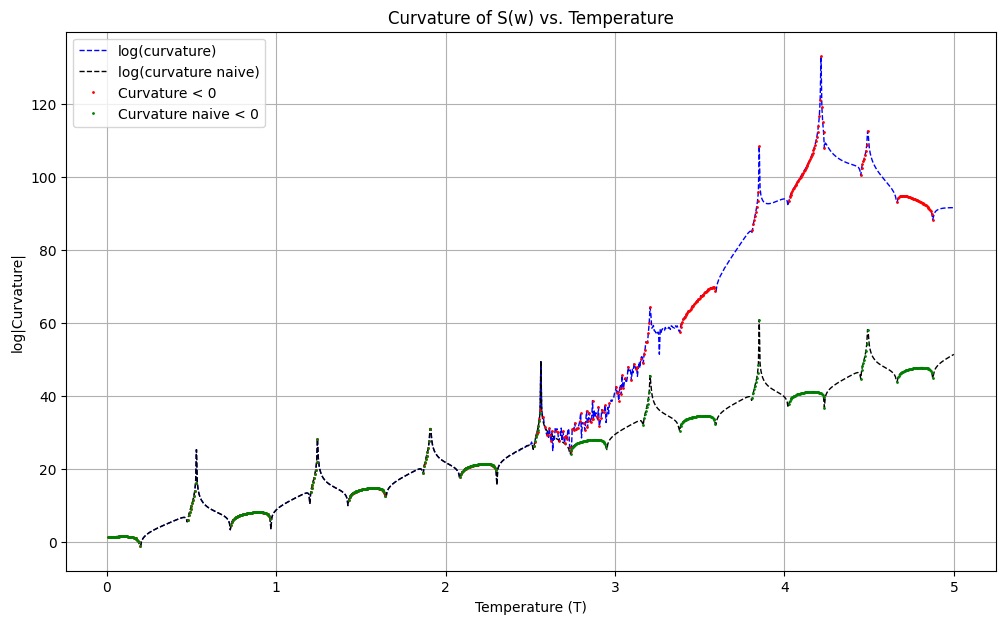

In [24]:
# --- 3. Plot the Results ---

plt.figure(figsize=(12, 7))
plt.plot(T_values, np.log(np.abs(R_z0_list)), 'r-', label='R(z_0)')
plt.plot(T_values, np.log(np.abs(R_z1_list)), 'b-', label='R(z_1)')
plt.plot(T_values, np.log(np.abs(R_naive_z0_list)), 'r--', label='R(z_0) naive')
plt.plot(T_values, np.log(np.abs(R_naive_z1_list)), 'b--', label='R(z_1) naive')
plt.title('Value of R(w) at the First Two Poles vs. Temperature')
plt.xlabel('Temperature (T)')
plt.ylabel('Magnitude of Residue')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 7))
plt.plot(T_values, residues_pole0, 'r-', label='|Res(S, z_0)|')
plt.plot(T_values, residues_pole1, 'b-', label='|Res(S, z_1)|')
plt.plot(T_values, residues_pole0_naive, 'r--', label='|Res(S, z_0) naive|')
plt.plot(T_values, residues_pole1_naive, 'b--', label='|Res(S, z_1) naive|')
plt.title('Residues of S(w) at the First Two Poles vs. Temperature')
plt.xlabel('Temperature (T)')
plt.ylabel('Magnitude of Residue')
plt.legend()
plt.grid(True)
plt.yscale('log')
plt.show()

# plot curvature with different colors for positive and negative
plt.figure(figsize=(12, 7))

# Convert to numpy arrays
curvature_arr = np.array(curvature)
curvature_naive_arr = np.array(curvature_naive)

# Split data based on sign
pos_mask = curvature_arr > 0
neg_mask = curvature_arr < 0
pos_mask_naive = curvature_naive_arr > 0
neg_mask_naive = curvature_naive_arr < 0

plt.plot(T_values, np.log(np.abs(curvature)), 'b--', label='log(curvature)', linewidth=1)
plt.plot(T_values, np.log(np.abs(curvature_naive)), 'k--', label='log(curvature naive)', linewidth=1)

# Plot curvature with different colors
#plt.plot(T_values[pos_mask], np.log(np.abs(curvature_arr[pos_mask])), 'b.', label='Curvature > 0', markersize=2)
plt.plot(T_values[neg_mask], np.log(np.abs(curvature_arr[neg_mask])), 'r.', label='Curvature < 0', markersize=2)

#plt.plot(T_values[pos_mask_naive], np.log(np.abs(curvature_naive_arr[pos_mask_naive])), 'k.', label='Curvature naive > 0', markersize=2)
plt.plot(T_values[neg_mask_naive], np.log(np.abs(curvature_naive_arr[neg_mask_naive])), 'g.', label='Curvature naive < 0', markersize=2)

plt.title('Curvature of S(w) vs. Temperature')
plt.xlabel('Temperature (T)')
plt.ylabel('log|Curvature|')
plt.legend()
plt.grid(True)
plt.show()



**Observation**:
- It seems that the curvature is the same as the analytic formula. I think this suggests that $R^p(\omega)=R^p_\Gamma(\omega)e^{ic\omega}$, which corresponds to a time translation. This is because the analytic continuation is based on $R^p(\omega)$ in a finite window of real $\omega$. With finite window we can always neglect the divergence at $\omega$ going to infinity. Not sure how to ensure the convergence at large cutoff limit.
- The analytic continuation fails at certain $\omega$ which depends on the cutoff. The failure seems to happen earlier when we start from a larger $\omega$ window. This might reflect some problem with taking Hilbert transform for a diverging function.

### Zoom in of the low temperature curvature

/Users/phynics/Documents/PII/mcp.science/servers/materials-project/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/phynics/Documents/PII/mcp.science/servers/materials-project/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


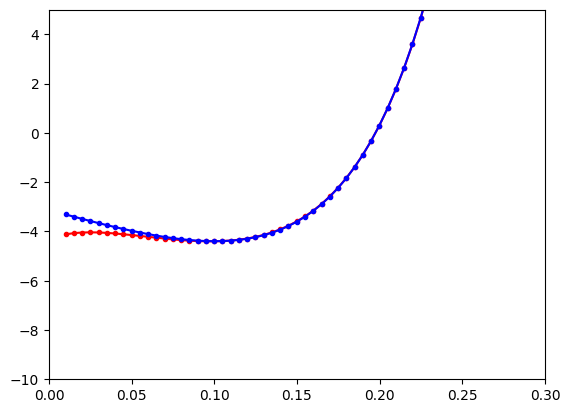

(-4.069567475492807+8.050647470442104e-16j)

In [27]:
plt.figure()

plt.plot(T_values,curvature,'r.-')
plt.plot(T_values,curvature_naive,'b.-')
plt.xlim([0,0.3])
plt.ylim([-10,5])
plt.show()

curvature[1]